In [1]:
%load_ext sppl.magics
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

In [2]:
%%sppl model
Nationality   ~= choice({'India': 0.5, 'USA': 0.5})
if (Nationality == 'India'):
    Perfect       ~= bernoulli(p=0.10)
    if (Perfect == 1):  GPA ~= atomic(loc=10)
    else:               GPA ~= uniform(loc=0, scale=10)
else:
    Perfect       ~= bernoulli(p=0.15)
    if (Perfect == 1):  GPA ~= atomic(loc=4)
    else:               GPA ~= uniform(loc=0, scale=4)

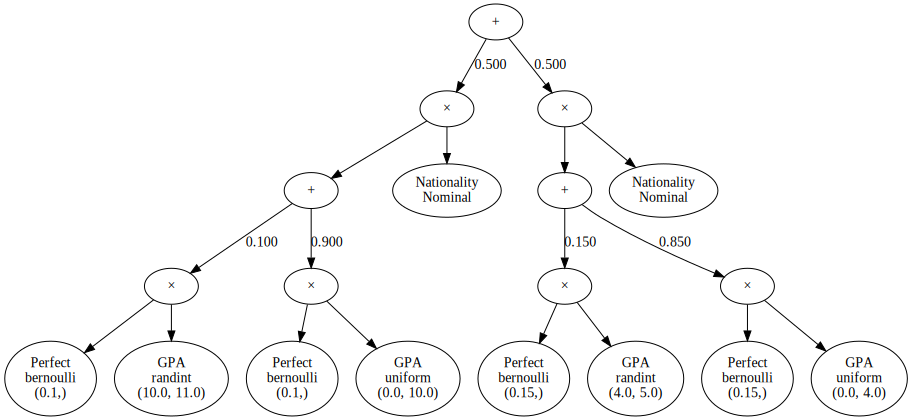

In [3]:
%sppl_to_graph model

In [4]:
n = %sppl_get_namespace model

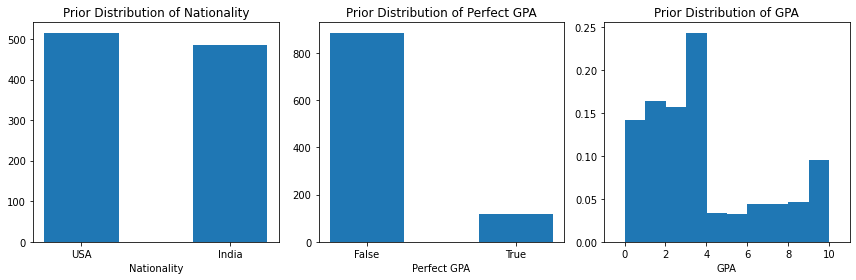

In [5]:
fig, ax = plt.subplots(ncols=3);
fig.set_size_inches(12, 4);
fig.set_tight_layout(True)
samples = n.model.sample(1000)

counts = Counter(s[n.Nationality] for s in samples)
ax[0].bar([0, 1], [counts['USA'], counts['India']], width=0.5)
ax[0].set_xticks([0, 1])
ax[0].set_xticklabels(['USA', 'India'])
ax[0].set_xlabel('Nationality');
ax[0].set_title('Prior Distribution of Nationality');

counts = Counter(s[n.Perfect] for s in samples)
ax[1].bar([0, 1], [counts[0], counts[1]], width=0.5)
ax[1].set_xticks([0, 1])
ax[1].set_xticklabels(['False', 'True'])
ax[1].set_xlabel('Perfect GPA')
ax[1].set_title('Prior Distribution of Perfect GPA');

ax[2].hist([s[n.GPA] for s in samples], density=True)
ax[2].set_xlim([-1, 11])
ax[2].set_xlabel('GPA')
ax[2].set_title('Prior Distribution of GPA');

In [6]:
# The probability of being perfect is 12.5%
n.model.prob(n.Perfect << {1})

0.12500000000000003

### Condition the model on student who is either "USA with GPA >3" or "GPA between 8 and 10".

In [7]:
event = (n.Nationality << {'USA'}) & (n.GPA > 3) | ((8 < n.GPA) < 10)
model_condition = n.model.condition(event)

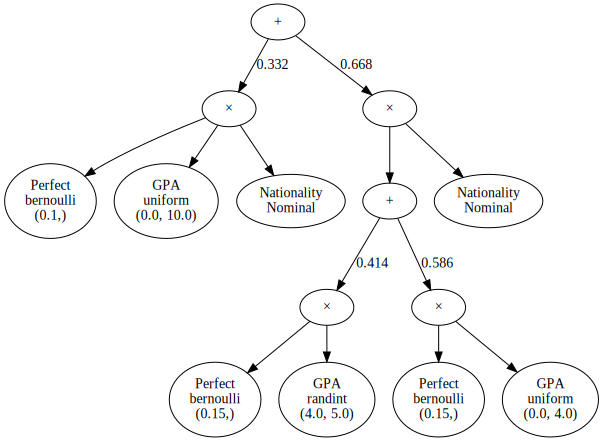

In [8]:
%sppl_to_graph model_condition

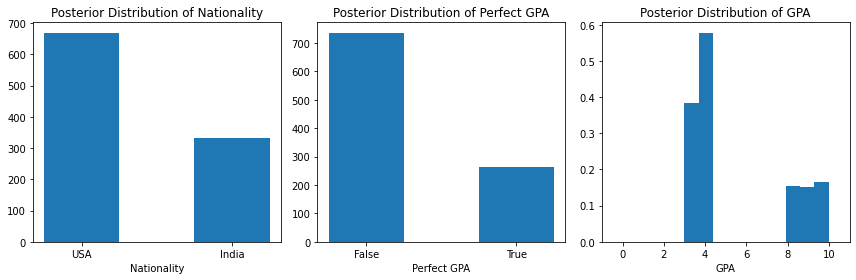

In [9]:
fig, ax = plt.subplots(ncols=3);
fig.set_size_inches(12, 4);
fig.set_tight_layout(True)

samples = model_condition.sample(1000)
counts = Counter(s[n.Nationality] for s in samples)
ax[0].bar([0, 1], [counts['USA'], counts['India']], width=0.5)
ax[0].set_xticks([0, 1])
ax[0].set_xticklabels(['USA', 'India'])
ax[0].set_xlabel('Nationality');
ax[0].set_title('Posterior Distribution of Nationality');

samples = model_condition.sample(1000)
counts = Counter(s[n.Perfect] for s in samples)
ax[1].bar([0, 1], [counts[0], counts[1]], width=0.5)
ax[1].set_xticks([0, 1])
ax[1].set_xticklabels(['False', 'True'])
ax[1].set_xlabel('Perfect GPA')
ax[1].set_title('Posterior Distribution of Perfect GPA');

samples = model_condition.sample(1000)
ax[2].set_xlim([-1, 11])
ax[2].hist([s[n.GPA] for s in samples], density=True)
ax[2].set_xlabel('GPA')
ax[2].set_title('Posterior Distribution of GPA');

#### Compare prior and posterior CDFs

In [10]:
eps = 0.005
xs_prior = [[-2, -eps], [eps, 4-20*eps], [4, 8], [8, 10-30*eps], [10, 12]]
cdfs_prior = [[n.model.prob(n.GPA <= y) for y in x] for x in xs_prior]

xs_post = [[-2, 3], [3, 4-10*eps], [4, 8], [8, 10, 12]]
cdfs_post = [[model_condition.prob(n.GPA <= y) for y in x] for x in xs_post]

In [11]:
import matplotlib.gridspec as gridspec

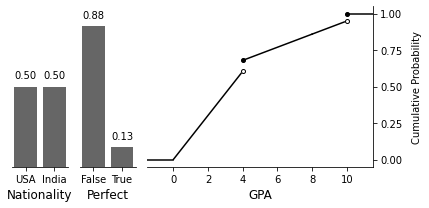

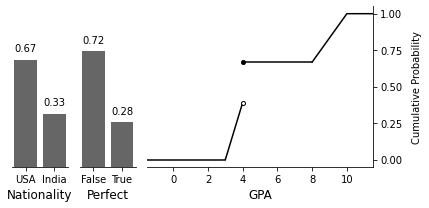

In [12]:
# fig, axes = plt.subplots(nrows=2, ncols=3)
figures = [plt.figure(), plt.figure()]
spec = fig.add_gridspec(nrows=1, ncols=3, width_ratios=[1,1,4])

axes = [
    [figures[0].add_subplot(spec[0]), figures[0].add_subplot(spec[1]), figures[0].add_subplot(spec[2])],
    [figures[1].add_subplot(spec[0]), figures[1].add_subplot(spec[1]), figures[1].add_subplot(spec[2])],
]
axes = np.asarray(axes)


barargs = dict(color='k', alpha=0.6)

# NATIONALITY
p_nationality_prior = [n.model.prob(n.Nationality<<{'USA'}), n.model.prob(n.Nationality<<{'India'})]
p_nationality_post = [model_condition.prob(n.Nationality<<{'USA'}), model_condition.prob(n.Nationality<<{'India'})]
axes[0,0].bar([0, 1], p_nationality_prior, **barargs)
axes[1,0].bar([0, 1], p_nationality_post, **barargs)
for i in [0, 1]:
    axes[0,0].text(i, p_nationality_prior[i]+.05, '%1.2f' % (p_nationality_prior[i]), ha='center')
    axes[1,0].text(i, p_nationality_post[i]+.05, '%1.2f' % (p_nationality_post[i]), ha='center')
for ax in axes[:,0]:
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['USA', 'India'])
    ax.set_ylim([0,1])
    # ax.set_ylabel('Probability')

# PERFECT
p_perfect_prior = [n.model.prob(n.Perfect<<{0}), n.model.prob(n.Perfect<<{1})]
p_perfect_post = [model_condition.prob(n.Perfect<<{0}), model_condition.prob(n.Perfect<<{1})]
axes[0,1].bar([0, 1], p_perfect_prior, **barargs)
axes[1,1].bar([0, 1], p_perfect_post, **barargs)
for i in [0, 1]:
    axes[0,1].text(i, p_perfect_prior[i]+.05, '%1.2f' % (p_perfect_prior[i]), ha='center')
    axes[1,1].text(i, p_perfect_post[i]+.05, '%1.2f' % (p_perfect_post[i]), ha='center')
for ax in axes[:,1]:
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['False', 'True'])
    ax.set_ylim([0,1])
    # ax.set_ylabel('Probability')

# GPA
mdict = dict(markersize=4, marker='o')
axes[0,2].plot(xs_prior[0], cdfs_prior[0], color='k')
axes[0,2].plot(xs_prior[1], cdfs_prior[1], color='k')
axes[0,2].plot(xs_prior[2], cdfs_prior[2], color='k', **mdict, markevery=[0])
axes[0,2].plot(xs_prior[3], cdfs_prior[3], color='k')
axes[0,2].plot(xs_prior[4], cdfs_prior[4], color='k', **mdict, markevery=[0])
axes[0,2].plot([4], [n.model.prob(n.GPA<=(4-eps))], color='k', **mdict, fillstyle='none')
axes[0,2].plot([10], [n.model.prob(n.GPA<=(10-eps))], color='k', **mdict, fillstyle='none')
# axes[0,2].text(3.7, 0.65, 'atom', color='k', ha='right')
# axes[0,2].text(9.7, 0.97, 'atom', color='k', ha='right')

axes[1,2].plot(xs_post[0], cdfs_post[0], color='k')
axes[1,2].plot(xs_post[1], cdfs_post[1], color='k')
axes[1,2].plot(xs_post[2], cdfs_post[2], color='k', **mdict, markevery=[0])
axes[1,2].plot(xs_post[3], cdfs_post[3], color='k')
axes[1,2].plot([4], [model_condition.prob(n.GPA<=(4-eps))], color='k', **mdict, fillstyle='none')
# axes[1,2].text(3.7, 0.65, 'atom', color='k', ha='right')

# Bar plots
for ax in np.ravel(axes[:,:2]):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_yticks([])

# CDF plot
for ax in axes[:,2]:
    # ax.set_ylabel('Cumulative Probability')
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_xlim([-1.5, 11.5])
    ax.set_yticks([0, 0.25, 0.50, .75, 1])
    ax.set_ylabel('Cumulative Probability', labelpad=10)
    ax.yaxis.set_label_position('right')
    ax.yaxis.tick_right()
    
# Titles
yshift=.99
fontsize=12
axes[0,0].set_xlabel('Nationality', fontsize=fontsize);
axes[1,0].set_xlabel('Nationality', fontsize=fontsize)
axes[0,1].set_xlabel('Perfect', fontsize=fontsize)
axes[1,1].set_xlabel('Perfect', fontsize=fontsize)
axes[0,2].set_xlabel('GPA', fontsize=fontsize)
axes[1,2].set_xlabel('GPA', fontsize=fontsize)

for i, fig in enumerate(figures):
    fig.set_tight_layout(True)
    fig.set_size_inches(6, 3)